# DSCI100 Group Project - 004-4

## Introduction
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
    - Can age, gender, and experience be used to predict played_hours?
- identify and fully describe the dataset that was used to answer the question

 **START BELOW**

Minecraft is a sandbox game made of blocks launched by Mojang Studios in 2011. There are lots of things to do in the game, from basic survival and building things from imagination, to collecting rare items and beating bosses, making minecraft a game suitable for all ages.

A research group in Computer Science at UBC, led by Frank Wood, set up a Mnecraft server to collect data about players' actions and demographics. In this project, we are using their collected data (players.csv) to answer our question:

 **Can the age of players be used to predict their number of hours played on Minecraft?**


**Data description (players.csv):**

Number of rows: 196 <br>
Number of columns(variables):7 <br>
| Variables | Types of var| Meaning | Data collection method|
|-------|-----|---------|-----------|
| experience  | character  |  player's experience of playing minecraft, categorized into 5 levels: Amateur,Beginner,Pro, Regular, Veteran | self-report |
| subscribe | logical  | whether the player has subscribed to the Minecraft newsletter  |either self-report or linked to self-reported email|
| hashedEmail | character | user identification, hashed for privacy reasons   |self-reoprt, verified by player and server|
| played_hours | double | number of hours played on Minecraft |recorded on Minecraft server|
| name  | character | player's names |self-report|
| gender | character  | player's gender  |self-report|
| Age | double  | player's age  |self-report|

## Methods and Results
- describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
- your report should include code which:
    - loads data 
    - wrangles and cleans the data to the format necessary for the planned analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    - performs the data analysis
    - creates a visualization of the analysis 
    - note: all figures should have a figure number and a legend


In [19]:
library(tidyverse)
library(janitor)

download.file("https://raw.githubusercontent.com/GraySchi/DSCI-Project-004-Group4/refs/heads/main/players%20(2).csv", "players.csv")
players_data <- read_csv(file = "players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [20]:
head(players_data)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [21]:
wrangled_players <- players_data |>
    clean_names() |>
    select(age, played_hours) |>
    filter(!is.na(age))
head(wrangled_players)

age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
17,0.0
21,0.7
21,0.1
17,0.0


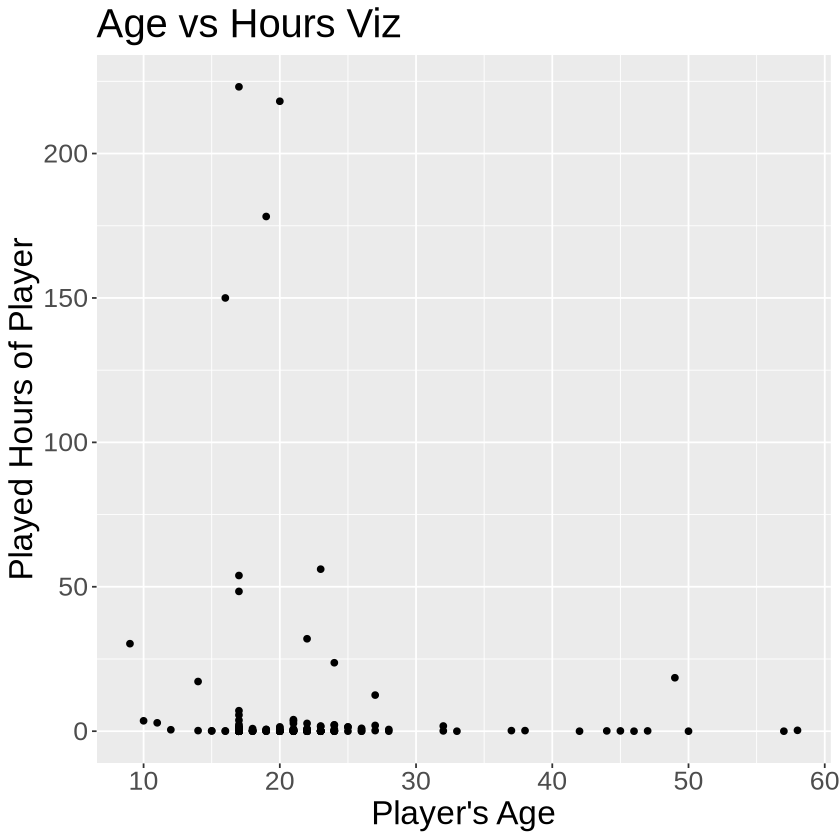

In [22]:
age_vs_hours_plot <- wrangled_players |>
    ggplot(aes(x=age, y=played_hours)) +
    geom_point() +
    labs(x="Player's Age", y="Played Hours of Player", title="Age vs Hours Viz") +
    theme(text = element_text(size=20))
age_vs_hours_plot

As you can see from the graph, it is hard to see a relation between played_hours and age. To fix this we will make some modifications to the data by applying log and filtering out players who played 0 hours.

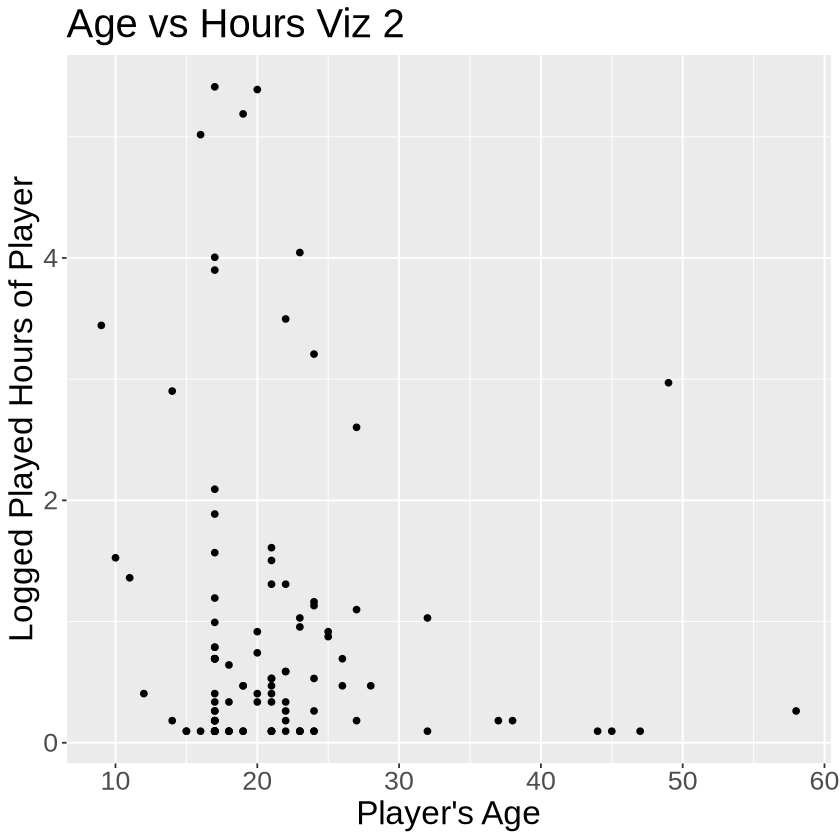

In [27]:
players_logged <- wrangled_players |>
    filter(played_hours > 0) |>
    mutate(played_hours = log(played_hours + 1))
logged_plot <- players_logged |>
    ggplot(aes(x=age, y=played_hours)) +
    geom_point() +
    labs(x="Player's Age", y="Logged Played Hours of Player", title="Age vs Hours Viz 2") +
    theme(text = element_text(size=20))
logged_plot

Here we see a better relation between played_hours and a players age. The graph seems to be right-skewed, with players around the age of 20 logging the highest hours.

## Discussion
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to

## References
- You may include references if necessary, as long as they all have a consistent citation style.